In [158]:
#best fit Elliott

In [159]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from numpy import genfromtxt

In [160]:
h = 6.62606957 * 10 ** (-34)
c0 = 299792458
charge = 1.602176565 * 10 ** (-19)
thickness = 1 * 10 ** (-5)

#\alpha(E, E_g, E_b)= \frac{b_{0}}{E} \sum_{n=1}^{\infty}{\frac{4\pi E_{B}^{\frac{3}{2}}}{n^{3}}\delta(E - (E_g - \frac{E_b}{n^2}))}+ \frac{b_{0}}{E}\frac{2\pi \sqrt{\frac{E_{b}}{E-E_{g}}}}{1-e^{-2\pi \sqrt{\frac{E_{b}}{E-E_{g}}}}}\sqrt{E-E_{g}}

In [161]:
#make a bunch of useful functions
def zero_remover(data):  #Only for lists
    zero_removed_data = []
    for i in range(0, len(data)):
        if data[i] > 0:
            zero_removed_data.append(data[i])
        else:
            zero_removed_data.append(0)
    zero_removed_data = np.array(zero_removed_data)
    return zero_removed_data

def csv_to_numpy(csv_file):
    all_data = genfromtxt(csv_file, delimiter=",", dtype=float, missing_values=["NaN", "#DIV/0!"], filling_values=0)
    all_data_removed_headers = all_data[2:, :]
    cleaned_data = np.where(all_data_removed_headers > 0, all_data_removed_headers, 0)
    return cleaned_data

def seperated_data(clean_data):
    wavelength = np.array(clean_data[:, 0])
    transmission0 = np.array(clean_data[:, 1])
    transmission100 = np.array(clean_data[:, 2])
    BA2PbI4 = np.array(clean_data[:, 3])
    SC_BA2MAPb2I7 = np.array(clean_data[:, 4])
    PC_BA2MAPb2I7 = np.array(clean_data[:, 5])

    energy_J = h * c0 / (wavelength * (10 ** (-9)))
    energy_eV = energy_J / charge
    incident = transmission100 - transmission0
    BA2PbI4_background = BA2PbI4 - transmission0
    SC_BA2MAPb2I7_background = SC_BA2MAPb2I7 - transmission0
    PC_BA2MAPb2I7_background = PC_BA2MAPb2I7 - transmission0
    return energy_eV, wavelength, incident, BA2PbI4_background, SC_BA2MAPb2I7_background, PC_BA2MAPb2I7_background

def all_calcs(incident, material):
    tranmission_material = (material / incident) * 100  #is this absorpTance & visa versa?
    absorbance = np.log10(incident / material)
    coefficient_literature = (np.log(10) / thickness) * absorbance
    return tranmission_material, absorbance, coefficient_literature

def format_sig_fig(x, sig_fig):
    """
    Format a number x to sig_fig significant figures,
    preserving trailing zeros as decimal places when needed.
    """
    if x == 0:
        return f"{0:.{sig_fig}f}"  # just return 0.00... for consistency
    # Determine how many digits before decimal
    import math
    digits_before_decimal = int(math.floor(math.log10(abs(x)))) + 1
    decimals_needed = max(sig_fig - digits_before_decimal, 0)
    return f"{x:.{decimals_needed}f}"

In [162]:
#Load in the data
directory = r"A:\Y4 Project code\Data\Raw data"
# Use glob to find all CSV files (recursively if needed)
csv_files = glob.glob(os.path.join(directory, "*.csv"))

data_dict = {}

for file in csv_files:
    key = os.path.splitext(os.path.basename(file))[0]
    #print(key)
    key = key.replace("Easy access data - ", "",
                      1)  #format == key.replace("old bit of key", "new bit of key", "counts(if counts == 1 then replaces all instances)")
    #print(key)
    short_key = key.split(" - ")[0].strip()
    short_key = short_key.split(" -")[0].strip()
    short_key = short_key.split("-")[0].strip()  # remove everything after the "-" in the item called "short_key"

    short_key = short_key.replace("m", "", 1)
    short_key = short_key.replace(" heat", "", 1)

    hours = int(short_key.split("h")[0].strip())
    #print(hours, "hours")
    minutes = int(short_key.split("h")[1].strip()) if len(short_key) > 1 and short_key.split("h")[1].strip() else 0
    #print(minutes, "minutes")
    if minutes > 30:
        hours = hours + 1

    #print(short_key)
    #print(key)
    data_dict[str(hours)] = csv_to_numpy(file)
print(data_dict.keys())
#print(data_dict["0"][:, 0])
#print(data_dict["0"][:, 1])
#print(data_dict["0"][:, 2])
#print(data_dict["0"][:, 3])
#print(data_dict["0"][:, 4])
#print(data_dict["0"][:, 5])

#the order of the keys is in the awful ['0', '139', '162', '167', '185', '192', '1', '209', '21', '215', '26', '44', '50', '67', '73'] order. We need to fix that
key_list = []
for key in data_dict.keys():
    key_list.append(int(key))
    correct_key_order = np.argsort(key_list)
print(correct_key_order)

correct_keys = []

for key in correct_key_order:
    correct_keys.append(key_list[key])

new_dict = {}

for key in correct_keys:
    new_dict[str(key)] = data_dict[str(key)]
data_dict = new_dict
print(data_dict.keys())  #viola!

dict_keys(['0', '139', '162', '167', '185', '192', '1', '209', '21', '215', '26', '44', '50', '67', '73'])
[ 0  6  8 10 11 12 13 14  1  2  3  4  5  7  9]
dict_keys(['0', '1', '21', '26', '44', '50', '67', '73', '139', '162', '167', '185', '192', '209', '215'])


In [163]:
#graph for ba2pbi4 = 1; graph for sc = 2; graph for pc = 3
#data is the key for the time period of the data

def getting_data(i, data):
    energy_eV, wavelength, incident, BA2PbI4_background, SC_BA2MAPb2I7_background, PC_BA2MAPb2I7_background = seperated_data(data)

    if i ==1:
        trans, absorb, absco = all_calcs(incident, BA2PbI4_background)
    elif i==2:
        trans, absorb, absco = all_calcs(incident, SC_BA2MAPb2I7_background)
    elif i==3:
        trans, absorb, absco = all_calcs(incident, PC_BA2MAPb2I7_background)
    else:
        print("Please enter a valid input of i between 1 --> 3")

    x = energy_eV
    #print(x.shape)
    y = absco
    #print(y.shape)

    for l in range(len(x)):
        value = x[l]
        if np.isnan(value):
            x[l] = 0.0
    for l in range(len(y)):
        value = y[l]
        if np.isnan(value) or not np.isfinite(value):
            y[l] = 0.0


    #getting the correct masks for the different materials

    start = h * c0 /(800 * charge* 10**-9)
    end = h * c0 /(450 * charge* 10**-9)

    mask_both = (x >= start) & (x <= end)
    x = x[mask_both]
    y = y[mask_both]/(1e5)

    if i == 1:
        mask_exciton = (x >= start) & (x <= h * c0 /(500 * charge* 10**-9))
        mask_general = (x >= h * c0 /(476 * charge* 10**-9)) & (x <= end)
    elif i == 2:
        mask_exciton = (x >= start) & (x <= h * c0 /(560 * charge* 10**-9))
        mask_general = (x >= 2.3) & (x <= end)
    elif i == 3:
        mask_exciton = (x >= start) & (x <= h * c0 /(560 * charge* 10**-9))
        mask_general = (x >= 2.3) & (x <= end)
    else:
        print("Please enter a valid input of i between 1 --> 3")

    x2 = x[mask_exciton]
    y2 = y[mask_exciton]
    x3 = x[mask_general]
    y3 = y[mask_general]
    return x, y, x2, y2, x3, y3

In [169]:
data = data_dict["0"]
i = 3
x, y, x2, y2, x3, y3 = getting_data(i, data)

C:\Users\user\AppData\Local\Temp\ipykernel_27504\1100359985.py:35: RuntimeWarning: divide by zero encountered in divide
  tranmission_material = (material / incident) * 100  #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_27504\1100359985.py:35: RuntimeWarning: invalid value encountered in divide
  tranmission_material = (material / incident) * 100  #is this absorpTance & visa versa?
C:\Users\user\AppData\Local\Temp\ipykernel_27504\1100359985.py:36: RuntimeWarning: divide by zero encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_27504\1100359985.py:36: RuntimeWarning: invalid value encountered in divide
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_27504\1100359985.py:36: RuntimeWarning: divide by zero encountered in log10
  absorbance = np.log10(incident / material)
C:\Users\user\AppData\Local\Temp\ipykernel_27504\1100359985.py:36: RuntimeWarning: invalid

C:\Users\user\AppData\Local\Temp\ipykernel_27504\3650805456.py:13: RuntimeWarning: invalid value encountered in scalar power
  summation_bit_pre_dirac_delta = (4* np.pi * (E_B**(3/2)))/(n**3)


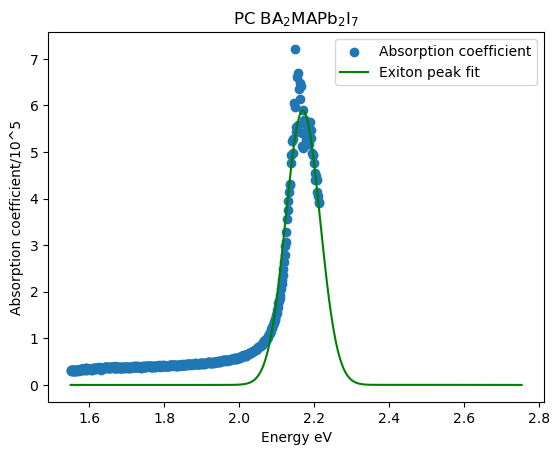

A = 0.0824 ± 109383.0054
E_G = 3.4314 ± 1122263.4913
E_B = 1.2608 ± 1122263.4660
sigma = 0.0458 ± 0.8584


In [170]:
def the_exiton_bit(x, A, E_G, E_B, sigma):
    first_bit = A/ x

    whole_summation_term = np.zeros_like(x, dtype=float)
    for n in range(1, 10):
        #dirac delta funciton
        prefactor = 1/(np.sqrt(2*np.pi*sigma**2))
        centre = E_G - (E_B/(n**2))
        exponential = np.exp(-((x-centre)**2)/(2*sigma**2))
        dirac_delta = prefactor * exponential

        #other elliot equation inside of the sumamtion
        summation_bit_pre_dirac_delta = (4* np.pi * (E_B**(3/2)))/(n**3)
        summation_term = summation_bit_pre_dirac_delta * dirac_delta

        whole_summation_term += summation_term
    return whole_summation_term * first_bit

params, covariance = curve_fit(the_exiton_bit, x2, y2, maxfev=100000)
# your initial guesses
A0 = 13.0932
EG0 = 2.3964
EB0 = 0.0113
sigma0 = 0.03

#p0 = [A0, EG0, EB0, test]
p0 = [A0, EG0, EB0, sigma0]

# Uncertainties (1σ standard deviations)
#(A_err, E_G_err, E_B_err, test_err) = np.sqrt(np.diag(covariance))
#A, E_G, E_B, test = params
(A_err, E_G_err, E_B_err, sigma_err) = np.sqrt(np.diag(covariance))
A, E_G, E_B, sigma = params

plt.scatter(x2, y2)
plt.plot(x, the_exiton_bit(x, *params), color='green')
plt.legend(['Absorption coefficient', "Exiton peak fit"])
plt.ylabel('Absorption coefficient/10^5')
plt.xlabel('Energy eV')
if i ==1:
    title = r"BA$_{2}$PbI$_{4}$"
if i ==2:
    title = r"SC BA$_{2}$MAPb$_{2}$I$_{7}$"
if i ==3:
    title = r"PC BA$_{2}$MAPb$_{2}$I$_{7}$"

plt.title(title)
plt.show()

print(f"A = {A:.4f} ± {A_err:.4f}")
print(f"E_G = {E_G:.4f} ± {E_G_err:.4f}")
print(f"E_B = {E_B:.4f} ± {E_B_err:.4f}")
print(f"sigma = {sigma:.4f} ± {sigma_err:.4f}")

C:\Users\user\AppData\Local\Temp\ipykernel_27504\199497495.py:9: RuntimeWarning: invalid value encountered in sqrt
  wierd_bit = 2*np.pi * np.sqrt(E_B/delta)


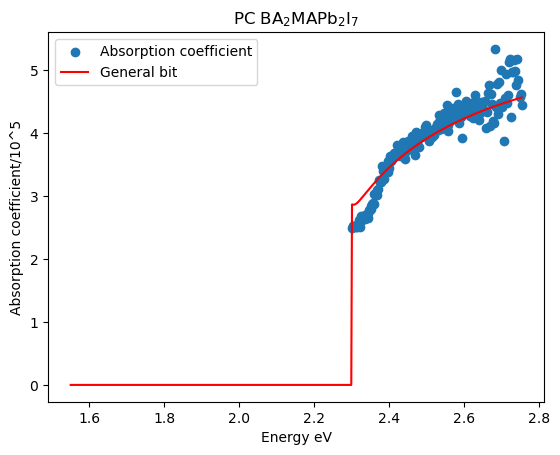

A = 13.1707 ± 0.1971
E_G = 2.3007 ± 0.0000
E_B = 0.0063 ± 0.0004


In [171]:
def general_bit(x, A, E_G, E_B):
    first_bit = A/ np.where(x == 0, np.inf, x)
    #first_bit = A

    #delta = np.maximum(x - E_G, 1e-6)
    delta = x-E_G
    bit_pre_JDoS = np.zeros_like(x)
    safe = delta > 0
    wierd_bit = 2*np.pi * np.sqrt(E_B/delta)
    wierd_bit = 2 * np.pi * np.sqrt(E_B/(delta[safe]))
    bit_pre_JDoS[safe] = wierd_bit / (1-np.exp(-wierd_bit))

    #JDoS bit
    JDoS = np.zeros_like(x)
    JDoS[safe] = np.sqrt(delta[safe])
    JDoS_term = JDoS * bit_pre_JDoS
    #JDoS_term = JDoS * bit_pre_JDoS/(1-test*(x-E_G))
    return first_bit * JDoS_term

params, covariance = curve_fit(general_bit, x3, y3, maxfev=100000)
# your initial guesses
A0 = 1
EG0 = 2.4
EB0 = 50e-3
test=0

#p0 = [A0, EG0, EB0, test]
p0 = [A0, EG0, EB0]

# Uncertainties (1σ standard deviations)
#(A_err, E_G_err, E_B_err, test_err) = np.sqrt(np.diag(covariance))
#A, E_G, E_B, test = params
(A_err, E_G_err, E_B_err) = np.sqrt(np.diag(covariance))
A, E_G, E_B= params

plt.scatter(x3, y3)
plt.plot(x, general_bit(x, *params), color='red')
plt.legend(['Absorption coefficient', 'General bit'])
plt.ylabel('Absorption coefficient/10^5')
plt.xlabel('Energy eV')
if i ==1:
    title = r"BA$_{2}$PbI$_{4}$"
if i ==2:
    title = r"SC BA$_{2}$MAPb$_{2}$I$_{7}$"
if i ==3:
    title = r"PC BA$_{2}$MAPb$_{2}$I$_{7}$"

plt.title(title)
plt.show()

print(f"A = {A:.4f} ± {A_err:.4f}")
print(f"E_G = {E_G:.4f} ± {E_G_err:.4f}")
print(f"E_B = {E_B:.4f} ± {E_B_err:.4f}")
#print(f"test = {test:.4f} ± {test_err:.4f}")

C:\Users\user\AppData\Local\Temp\ipykernel_27504\3111661708.py:28: RuntimeWarning: invalid value encountered in sqrt
  wierd_bit = 2*np.pi * np.sqrt(E_B/delta)


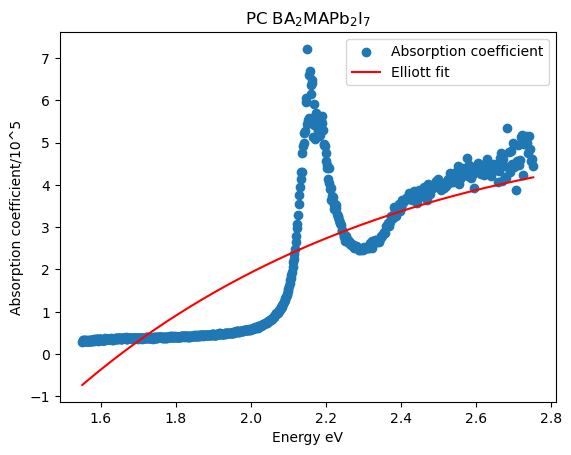

A = -4.4310 ± 1004.7916
B = 2.7228 ± 171.2924
E_G = 1.5504 ± 309.9038
E_B = 2.0074 ± 309.3300
sigma = 1.9208 ± 32.3798


In [172]:
#trying to plot both
def Elliott(x, A, B, E_G, E_B, sigma):
    #Exiton bit
    first_bit = A/ x

    whole_summation_term = np.zeros_like(x, dtype=float)
    for n in range(1, 10):
        #dirac delta funciton
        prefactor = 1/(np.sqrt(2*np.pi*sigma**2))
        centre = E_G - (E_B/(n**2))
        exponential = np.exp(-((x-centre)**2)/(2*sigma**2))
        dirac_delta = prefactor * exponential

        #other elliot equation inside of the sumamtion
        summation_bit_pre_dirac_delta = (4* np.pi * (E_B**(3/2)))/(n**3)
        summation_term = summation_bit_pre_dirac_delta * dirac_delta

        whole_summation_term += summation_term
    Exiton_bit = whole_summation_term * first_bit

    #general bit
    first_bit = B/ np.where(x == 0, np.inf, x)

        #delta = np.maximum(x - E_G, 1e-6)
    delta = x-E_G
    bit_pre_JDoS = np.zeros_like(x)
    safe = delta > 0
    wierd_bit = 2*np.pi * np.sqrt(E_B/delta)
    wierd_bit = 2 * np.pi * np.sqrt(E_B/(delta[safe]))
    bit_pre_JDoS[safe] = wierd_bit / (1-np.exp(-wierd_bit))

        #JDoS bit
    JDoS = np.zeros_like(x)
    JDoS[safe] = np.sqrt(delta[safe])
    JDoS_term = JDoS * bit_pre_JDoS

    General_bit = first_bit * JDoS_term
    return (General_bit + Exiton_bit)


params, covariance = curve_fit(Elliott, x, y, maxfev=100000)

#initial guesses
A0 = 0.0348
B0 = 13.0932
EG0 = 3
EB0 = 1
sigma0 = 0.05

p0 = [A0, B0, EG0, EB0, sigma0]

# Uncertainties (1σ standard deviations)
#(A_err, E_G_err, E_B_err, test_err) = np.sqrt(np.diag(covariance))
#A, E_G, E_B, test = params
(A_err, B_err, E_G_err, E_B_err, sigma_err) = np.sqrt(np.diag(covariance))
A, B, E_G, E_B, sigma= params

plt.scatter(x, y)
plt.plot(x, Elliott(x, *params), color='red')
plt.legend(['Absorption coefficient', 'Elliott fit'])
plt.ylabel('Absorption coefficient/10^5')
plt.xlabel('Energy eV')
if i ==1:
    title = r"BA$_{2}$PbI$_{4}$"
if i ==2:
    title = r"SC BA$_{2}$MAPb$_{2}$I$_{7}$"
if i ==3:
    title = r"PC BA$_{2}$MAPb$_{2}$I$_{7}$"

plt.title(title)
plt.show()

print(f"A = {A:.4f} ± {A_err:.4f}")
print(f"B = {B:.4f} ± {B_err:.4f}")
print(f"E_G = {E_G:.4f} ± {E_G_err:.4f}")
print(f"E_B = {E_B:.4f} ± {E_B_err:.4f}")
print(f"sigma = {sigma:.4f} ± {sigma_err:.4f}")

C:\Users\user\AppData\Local\Temp\ipykernel_27504\3650805456.py:13: RuntimeWarning: invalid value encountered in scalar power
  summation_bit_pre_dirac_delta = (4* np.pi * (E_B**(3/2)))/(n**3)
C:\Users\user\AppData\Local\Temp\ipykernel_27504\199497495.py:9: RuntimeWarning: invalid value encountered in sqrt
  wierd_bit = 2*np.pi * np.sqrt(E_B/delta)
C:\Users\user\AppData\Local\Temp\ipykernel_27504\199497495.py:10: RuntimeWarning: invalid value encountered in sqrt
  wierd_bit = 2 * np.pi * np.sqrt(E_B/(delta[safe]))


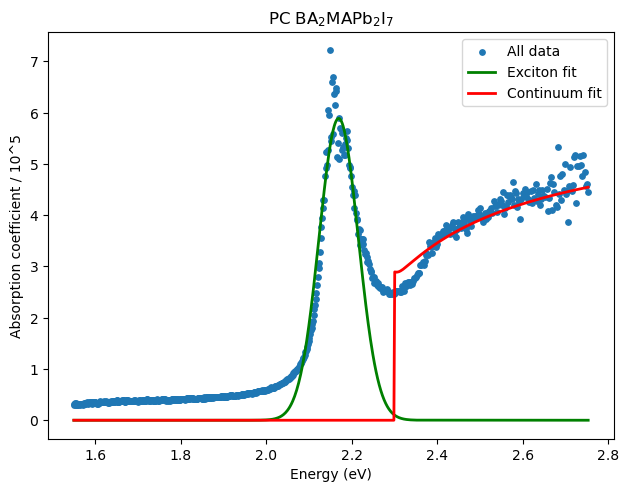

===== Exciton Peak Fit =====
A = 0.0930 ± 125559.0239
E_G = 3.3338 ± 1047167.8522
E_B = 1.1632 ± 1047167.8394
sigma = 0.0458 ± 0.7667

===== Continuum Fit =====
A = 13.0423 ± 0.2034
E_G = 2.3007 ± 0.0000
E_B = 0.0066 ± 0.0004


In [175]:
# ---- FIT 1: Exciton peaks ----
p0_exiton = [A0, EG0, EB0, sigma0]
params_exiton, cov_exiton = curve_fit(the_exiton_bit, x2, y2, p0=p0_exiton, maxfev=100000)

# ---- FIT 2: General continuum ----
p0_general = [1, 2.4, 50e-3]
params_general, cov_general = curve_fit(general_bit, x3, y3, p0=p0_general, maxfev=100000)

# ---- SINGLE PLOT ----
#plt.figure(figsize=(8,6))

# All raw data
plt.scatter(x, y, s=15, label="All data")

# Exciton model
plt.plot(x,
         the_exiton_bit(x, *params_exiton),
         color='green',
         linewidth=2,
         label="Exciton fit")

# General continuum model
plt.plot(x,
         general_bit(x, *params_general),
         color='red',
         linewidth=2,
         label="Continuum fit")
#plt.plot(x, the_exiton_bit(x, *params_exiton) + general_bit(x, *params_general), color='blue',
         #linewidth=2,
         #label="Exciton fit")

plt.xlabel("Energy (eV)")
plt.ylabel("Absorption coefficient / 10^5")
plt.legend()
plt.tight_layout()

if i ==1:
    title = r"BA$_{2}$PbI$_{4}$"
if i ==2:
    title = r"SC BA$_{2}$MAPb$_{2}$I$_{7}$"
if i ==3:
    title = r"PC BA$_{2}$MAPb$_{2}$I$_{7}$"

plt.title(title)
plt.show()

#Do we want the parameters and the errors? YES! --- When do we want them? NOW!
A_ex, E_G_ex, E_B_ex, sigma_ex = params_exiton
(A_ex_err, E_G_ex_err, E_B_ex_err, sigma_ex_err) = np.sqrt(np.diag(cov_exiton))
print("===== Exciton Peak Fit =====")
print(f"A = {A_ex:.4f} ± {A_ex_err:.4f}")
print(f"E_G = {E_G_ex:.4f} ± {E_G_ex_err:.4f}")
print(f"E_B = {E_B_ex:.4f} ± {E_B_ex_err:.4f}")
print(f"sigma = {sigma_ex:.4f} ± {sigma_ex_err:.4f}")

A_gen, E_G_gen, E_B_gen = params_general
(A_gen_err, E_G_gen_err, E_B_gen_err) = np.sqrt(np.diag(cov_general))
print("\n===== Continuum Fit =====")
print(f"A = {A_gen:.4f} ± {A_gen_err:.4f}")
print(f"E_G = {E_G_gen:.4f} ± {E_G_gen_err:.4f}")
print(f"E_B = {E_B_gen:.4f} ± {E_B_gen_err:.4f}")